# Preparation

### Import and constants

In [31]:
import numpy as np
from numpy.random import seed
seed(12345)

import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, Reshape, MaxPooling2D
from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.utils import Sequence

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

from google.colab import drive
from google.colab.patches import cv2_imshow

In [2]:
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [3]:
#get name of image with index
def file_name(image_num):
  return "image{}.jpg".format(image_num)

#get full path of image with index
def file_path(image_num):
  folder = 'drive/MyDrive/Colab Notebooks/StreetCamera_XX'
  return os.path.join(folder,file_name(image_num))

In [4]:
def show_results(history):
  # Show training history (this cell is complete, nothing to implement here :-) )
  h = history.history
  epochs = range(len(h['loss']))

  plt.subplot(121), plt.plot(epochs, h['loss'], '.-', epochs, h['val_loss'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('loss')
  plt.legend(['Train', 'Validation'])
  plt.subplot(122), plt.plot(epochs, h['accuracy'], '.-',
                            epochs, h['val_accuracy'], '.-')
  plt.grid(True), plt.xlabel('epochs'), plt.ylabel('Accuracy')
  plt.legend(['Train', 'Validation'])

  print('Train Acc     ', h['accuracy'][-1])
  print('Validation Acc', h['val_accuracy'][-1])

In [5]:
def comparison(test_dataset, decoded_imgs, n):
  for ii in range(n):
      image_num = np.random.randint(0, len(test_dataset))

      plt.subplot(2,n,ii+1), plt.imshow(test_dataset[image_num, ...])
      plt.title("original")

      plt.subplot(2,n,ii+1+n), plt.imshow(decoded_imgs[image_num, ...])
      plt.title("reconstructed")

In [32]:
class DataGenerator(Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

###Data preparation


In [6]:
# Load data from the folder
train_dataset = []
test_dataset = []
for image_num in range(0,21553,4): #we will take not all data for the first time
  img = cv2.imread(file_path(image_num))
  if img is not None:
    train_dataset.append(img)

for image_num in range(1,21554,16): #this way be another data
  img = cv2.imread(file_path(image_num))
  if img is not None:
    test_dataset.append(img)

train_dataset = np.array(train_dataset)
test_dataset = np.array(test_dataset)

In [7]:
hight = train_dataset.shape[1]
width = train_dataset.shape[2]

### Data inspaction

In [8]:
print('Train set:   ', len(train_dataset), 'samples')
print('Test set:    ', len(test_dataset), 'samples')
print('Sample dims: ', train_dataset.shape)

Train set:    5389 samples
Test set:     1348 samples
Sample dims:  (5389, 108, 192, 3)


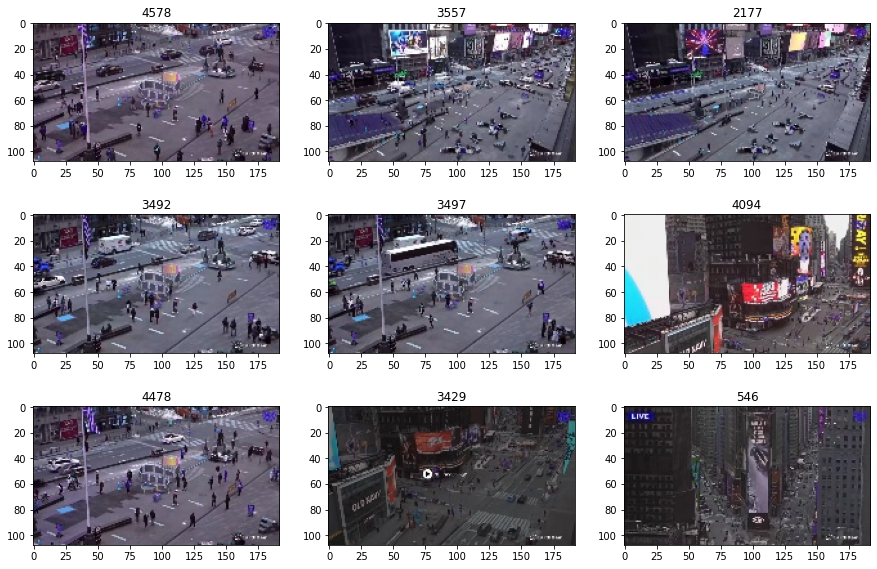

In [9]:
# Show random samples
for ii in range(9):
    image_num = np.random.randint(0, len(train_dataset))
    plt.subplot(3,3,ii+1), plt.imshow(train_dataset[image_num, ...])
    plt.title(str(image_num))

#Building model

In [10]:
# Normalization

train_dataset = train_dataset.astype('float32')/255
#for ii in range(len(train_dataset)):
#  train_dataset[ii, ...] = train_dataset[ii, ...]/255

test_dataset = test_dataset.astype('float32')/255

## Simple model (etalon)

In [11]:
latent_dim = 5000 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      Flatten(),
      Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      Dense(width*hight*3, activation='sigmoid'),
      Reshape((hight, width, 3))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [12]:
autoencoder.compile(optimizer='adam', loss=MeanSquaredError(), metrics=["accuracy"])
autoencoder.summary()

In [13]:
epochs = 50
batch_size = 32
history = autoencoder.fit(train_dataset, train_dataset,
                epochs=epochs,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

Epoch 1/50
169/169 [==============================] - 27s 146ms/step - loss: 0.0164 - accuracy: 0.6486 - val_loss: 0.0081 - val_accuracy: 0.7770
Epoch 2/50
169/169 [==============================] - 24s 141ms/step - loss: 0.0073 - accuracy: 0.7865 - val_loss: 0.0073 - val_accuracy: 0.7810
Epoch 3/50
169/169 [==============================] - 24s 140ms/step - loss: 0.0068 - accuracy: 0.8093 - val_loss: 0.0064 - val_accuracy: 0.8205
Epoch 4/50
169/169 [==============================] - 24s 140ms/step - loss: 0.0062 - accuracy: 0.8249 - val_loss: 0.0062 - val_accuracy: 0.8292
Epoch 5/50
169/169 [==============================] - 24s 140ms/step - loss: 0.0060 - accuracy: 0.8256 - val_loss: 0.0063 - val_accuracy: 0.7991
Epoch 6/50
169/169 [==============================] - 24s 140ms/step - loss: 0.0060 - accuracy: 0.8200 - val_loss: 0.0062 - val_accuracy: 0.8205
Epoch 7/50
169/169 [==============================] - 24s 140ms/step - loss: 0.0067 - accuracy: 0.8052 - val_loss: 0.0063 - val_ac

Train Acc      0.8339409828186035
Validation Acc 0.8285434246063232


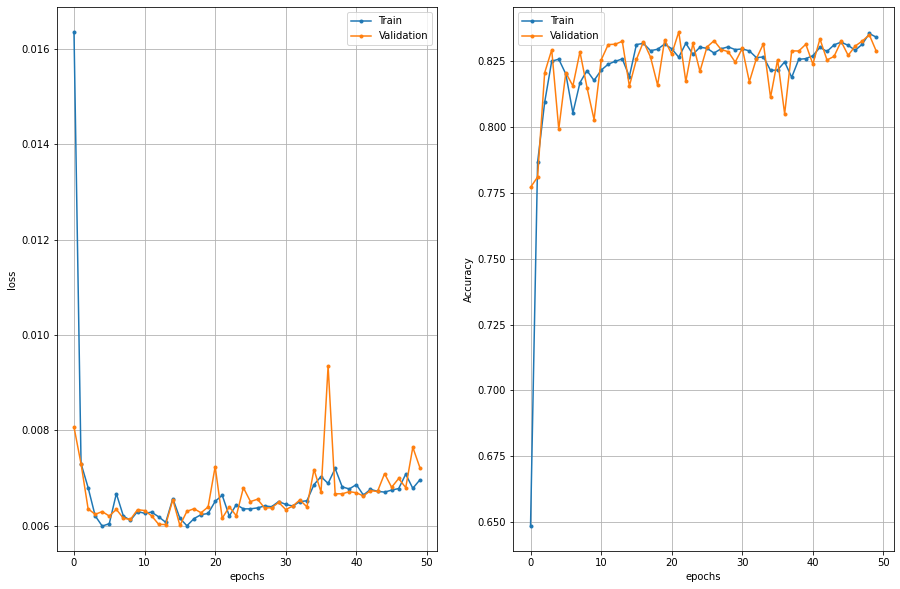

In [14]:
show_results(history)

In [15]:
encoded_imgs = autoencoder.encoder(test_dataset).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [16]:
print('Sample encoded: ', encoded_imgs.shape)
print('Sample decoded: ', decoded_imgs.shape)
print('comression: ', decoded_imgs.shape[1]*decoded_imgs.shape[2]*decoded_imgs.shape[3]/decoded_imgs.shape[1])

Sample encoded:  (1348, 5000)
Sample decoded:  (1348, 108, 192, 3)
comression:  576.0


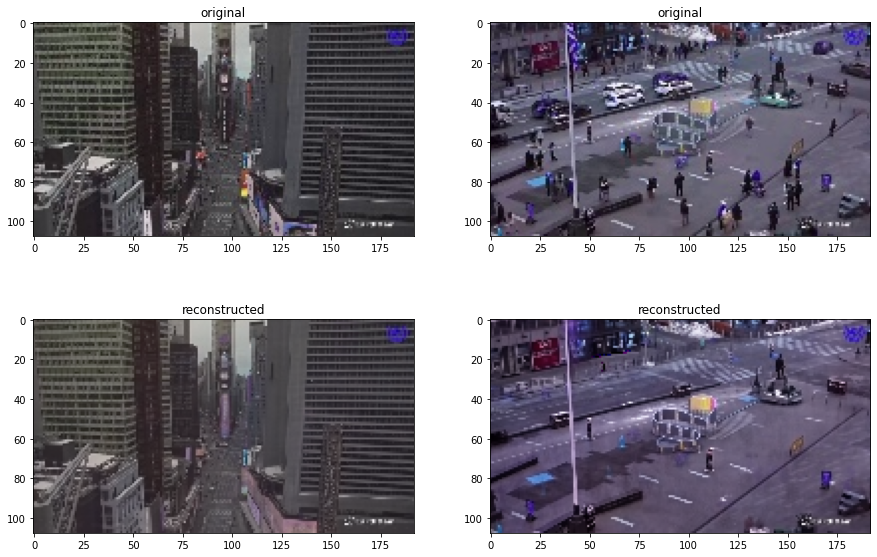

In [17]:
# Show random comparison
comparison(test_dataset, decoded_imgs, 2)